# Prompt-to-Prompt: Attention Re-weighting 🚀
![teaser.png](https://i.imgur.com/ViFQxxF.png)

* **Paper**: [Prompt-to-Prompt Image Editing with Cross Attention Control](https://arxiv.org/abs/2208.01626)

* **Github**: https://github.com/miguelCalado/prompt-to-prompt-tensorflow

# Imports

In [1]:
import random

import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib import gridspec
from matplotlib import pylab as P
from PIL import Image

from stable_diffusion import StableDiffusion

In [2]:
# Utility function
def ShowImage(im, ax=None, save_fig=None):
    if ax is None:
        P.figure()
    P.xticks([])
    P.yticks([])
    P.imshow(im)
    if save_fig:
        P.savefig(
            save_fig, dpi=200, bbox_inches="tight", pad_inches=0.0, transparent="True"
        )

# Setup GPU Strategy

In [3]:
gpus = tf.config.list_physical_devices("GPU")
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  1


2022-12-26 10:35:44.690641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 10:35:44.696089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 10:35:44.696247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
strategy = tf.distribute.get_strategy()

# Prompt-to-Prompt: Attention Re-weighting

In [5]:
generator = StableDiffusion(
    strategy=strategy,
    img_height=512,
    img_width=512,
    jit_compile=False,
)

2022-12-26 10:35:44.826070: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-26 10:35:44.826647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 10:35:44.826833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 10:35:44.826948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Pineapple Pizza Example

In [6]:
prompt = "a photo of a pizza with pineapple"
num_steps = 50
unconditional_guidance_scale = 8
batch_size = 1
seed = 1234

img = generator.text_to_image(
    prompt=prompt,
    num_steps=num_steps,
    unconditional_guidance_scale=unconditional_guidance_scale,
    seed=seed,
    batch_size=batch_size,
)

2022-12-26 10:36:11.859675: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
  0   1: 100%|██████████| 50/50 [00:29<00:00,  1.68it/s]


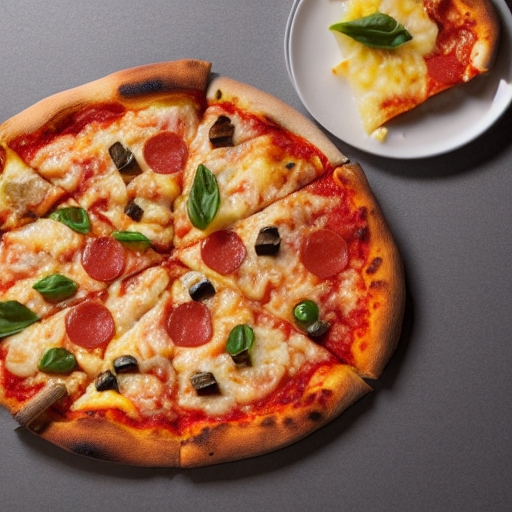

In [7]:
pil_img = Image.fromarray(img[0])
display(pil_img)

In [8]:
prompt = "a photo of a pizza with pineapple"
prompt_weights = [("pineapple", 2)]
prompt_weights = generator.create_prompt_weights(prompt, prompt_weights, batch_size=1)

In [9]:
# Clean up the session to avoid clutter from old models and layers
tf.keras.backend.clear_session()

img = generator.text_to_image(
    prompt=prompt,
    num_steps=num_steps,
    unconditional_guidance_scale=unconditional_guidance_scale,
    prompt_weights=prompt_weights,
    seed=seed,
    batch_size=batch_size,
)

  0   1: 100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


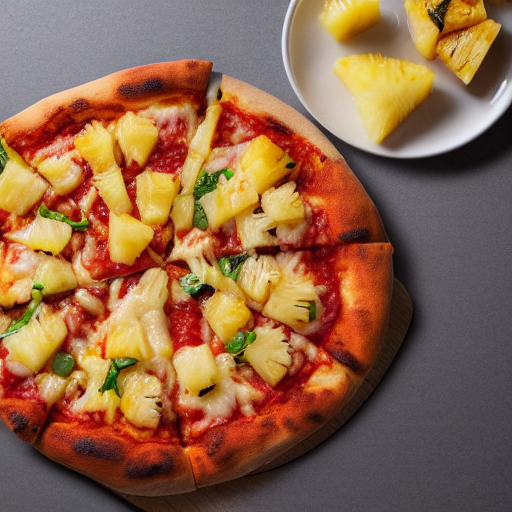

In [10]:
pil_img = Image.fromarray(img[0])
display(pil_img)

In [11]:
list_imgs = []
title_list = []
for weight in range(10, 20, 2):

    weight = weight / 10
    prompt_weights = [("pineapple", weight)]
    prompt_weights = generator.create_prompt_weights(
        prompt, prompt_weights, batch_size=1
    )

    # Clean up the session to avoid clutter from old models and layers
    tf.keras.backend.clear_session()

    img = generator.text_to_image(
        prompt=prompt,
        num_steps=num_steps,
        unconditional_guidance_scale=unconditional_guidance_scale,
        prompt_weights=prompt_weights,
        seed=seed,
        batch_size=batch_size,
    )
    title_list.append("Original Image" if weight == 1 else f"t={weight}")
    list_imgs.append(img[0])

  0   1: 100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


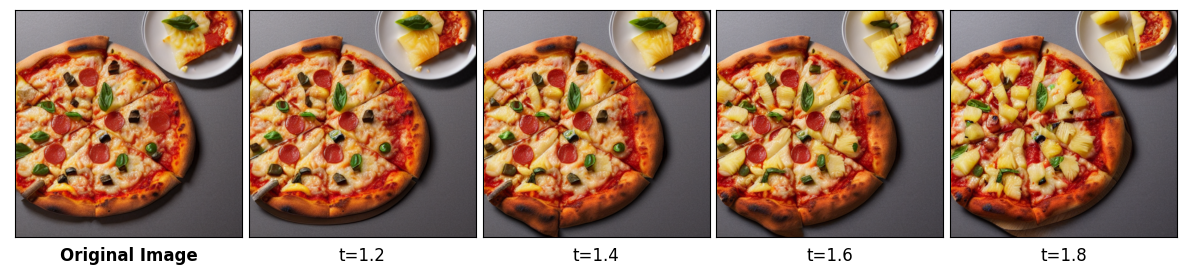

In [12]:
ROWS = 1  # 11
COLS = 5  # 11
FACTOR = 3

fig = plt.figure(figsize=(COLS * FACTOR, ROWS * FACTOR))
gs = gridspec.GridSpec(ROWS, COLS, wspace=0.01 * FACTOR, hspace=0.0 * FACTOR)
i = 0
j = 0
for gen_img, title in zip(list_imgs, title_list):
    ShowImage(gen_img, ax=P.subplot(gs[i, j]))
    if j:
        P.xlabel(title, fontsize=12)
    else:
        P.xlabel(title, fontsize=12, fontweight="bold")
    j += 1